1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

from xgboost import XGBClassifier


2. Load Dataset

In [2]:
df = pd.read_csv("heart_disease_data.csv")  
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
df["target"] = 1 - df["target"]

3. Exploratory Data Analysis

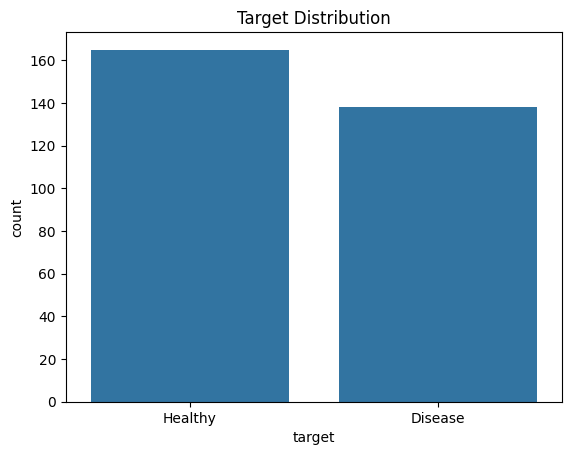

In [5]:
sns.countplot(x="target", data=df)
plt.xticks([0,1], ["Healthy", "Disease"])
plt.title("Target Distribution")
plt.show()

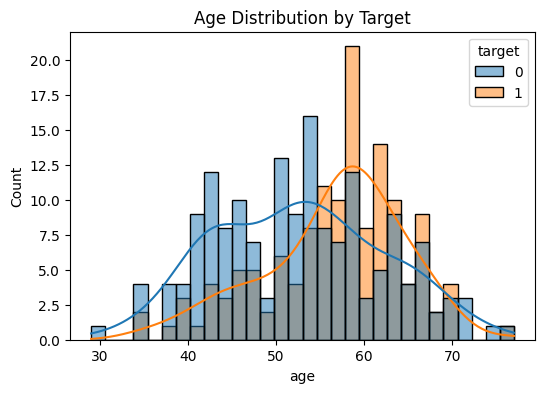

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="age", hue="target", bins=30, kde=True)
plt.title("Age Distribution by Target")
plt.show()

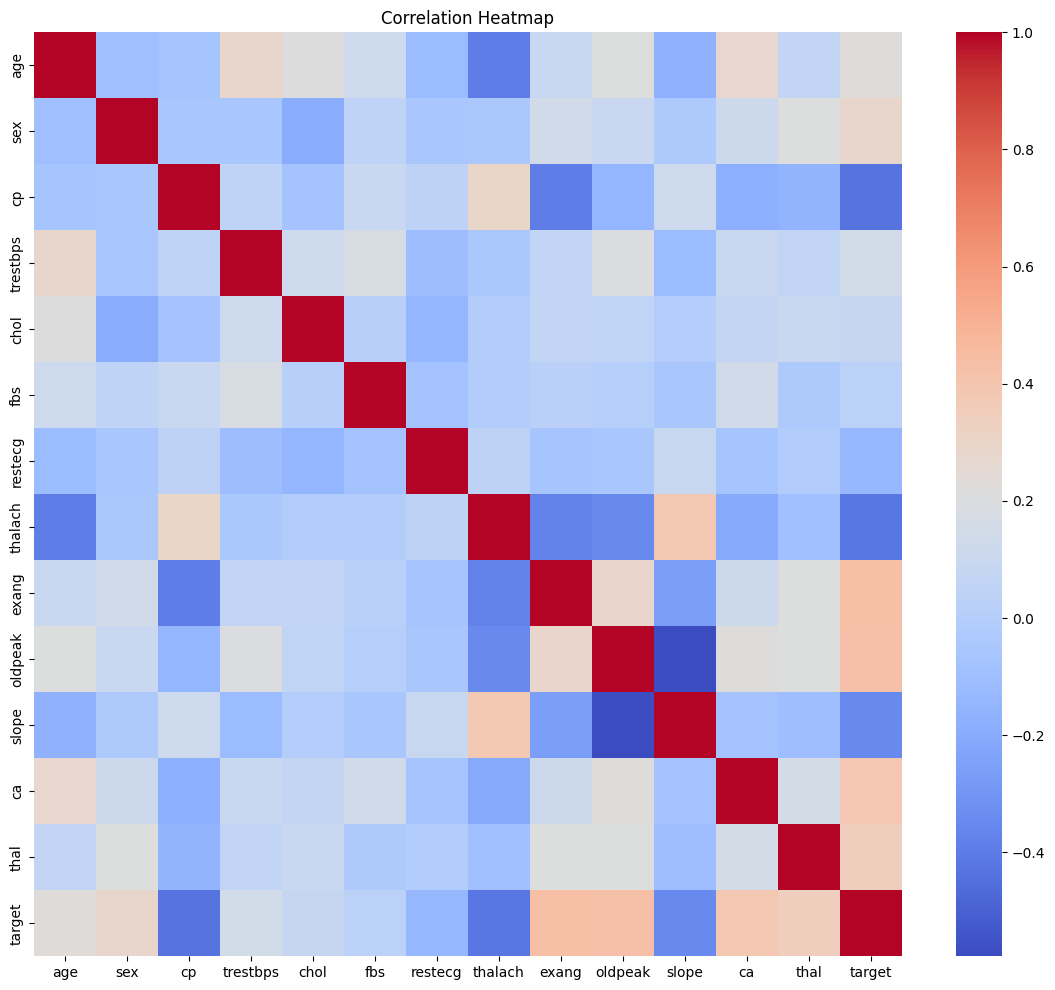

In [7]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

4.Feature Engineering

In [8]:
FEATURES = [
    "age","sex","cp","trestbps","chol","fbs",
    "restecg","thalach","exang","oldpeak",
    "slope","ca","thal"
]

X = df[FEATURES]
y = df["target"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


5. Feature Scaling

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
#Handle Class Imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
scale_pos_weight

1.2

6. Baseline XGBoost Model

In [12]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

7. Hyperparameter Tuning

In [13]:
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.01, 0.05], 'max_depth': [3, 4, 5],
                         'n_estimators': [200, 300], 'subsample': [0.8, 0.9]},
             scoring='roc_auc', verbose=1)

8.Best Model

In [14]:
best_model = grid.best_estimator_
grid.best_params_


{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.9}

7. Model Evaluation

In [15]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1]


In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy","Disease"]))


Accuracy: 0.8032786885245902
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1-score: 0.7692307692307693
ROC-AUC: 0.9188311688311688

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.78      0.88      0.83        33
     Disease       0.83      0.71      0.77        28

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



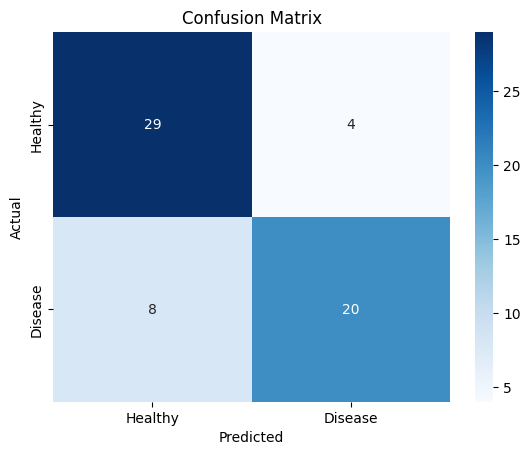

In [17]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Healthy","Disease"],
    yticklabels=["Healthy","Disease"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


10. Save Model & Scaler

In [18]:
joblib.dump(scaler, "heart_scaler.pkl")

joblib.dump(
    {
        "model": best_model,
        "features": FEATURES
    },
    "heart_xgboost_model.pkl"
)


['heart_xgboost_model.pkl']

In [19]:
def predict_heart_disease(input_data, threshold=0.4):
    df_input = pd.DataFrame([input_data])
    df_input = df_input[FEATURES]

    scaled = scaler.transform(df_input)
    prob = best_model.predict_proba(scaled)[0,1]

    label = "HIGH RISK – HEART DISEASE" if prob >= threshold else "LOW RISK – HEALTHY"

    return {
        "prediction": label,
        "risk_probability": round(prob * 100, 2)
    }


In [20]:
test_case = {
    "age": 80,
    "sex": 1,
    "cp": 0,
    "trestbps": 166,
    "chol": 474,
    "fbs": 1,
    "restecg": 1,
    "thalach": 150,
    "exang": 1,
    "oldpeak": 5.2,
    "slope": 2,
    "ca": 3,
    "thal": 2
}

predict_heart_disease(test_case)


{'prediction': 'HIGH RISK – HEART DISEASE', 'risk_probability': 82.3}

In [22]:
test_case_2= {
    "age": 45,
    "sex": 0,
    "cp": 2,
    "trestbps": 118,
    "chol": 190,
    "fbs": 0,
    "restecg": 0,
    "thalach": 170,
    "exang": 0,
    "oldpeak": 0.3,
    "slope": 0,
    "ca": 0,
    "thal": 1
}
predict_heart_disease(test_case_2)

{'prediction': 'LOW RISK – HEALTHY', 'risk_probability': 8.39}